In [43]:
import os
import glob
import time

import pandas as pd
import numpy as np
import xarray as xr
import datetime
from netCDF4 import Dataset


import matplotlib
from matplotlib import pyplot as plt
from matplotlib.ticker import NullFormatter
matplotlib.rcParams.update({'font.size': 16})
%matplotlib inline
import cartopy.crs as ccrs
import cartopy

import sys
p = os.path.abspath('../..')
if p not in sys.path:
    sys.path.append(p)

from tools.generalTools import qsat,upslope_omega_sin
from orographicPrecipitation.precip_extremes_scaling import *
from wrfProcessing import *

import warnings
from tabulate import tabulate

In [44]:
def extract_wrfout(simulation_path):
    files=sorted(glob.glob(simulation_path+'wrfout_d01_197*'))
    return xr.open_mfdataset(files,combine='nested',concat_dim='Time',parallel=True)

def hemi_average(ds):
    return (ds.isel(south_north=range(69,-1,-1))+ds.isel(south_north=range(70,140)))/2

def sel_crosseqtropicmountain(ds):
    return ds.sel(west_east=slice(38,41),south_north=slice(64,75))

def mean_mountain(x):
    return sel_crosseqtropicmountain(x).mean(['west_east','south_north'])

Mcontwrf = extract_wrfout("/global/cscratch1/sd/qnicolas/wrfdata/saved/new.wrf.crosseq.mountain.100km.1000d/")


In [45]:
%%time
allprecip = 4*(Mcontwrf.RAINC+Mcontwrf.RAINNC).diff('Time').persist()

CPU times: user 1.28 s, sys: 11.9 s, total: 13.1 s
Wall time: 1min 43s


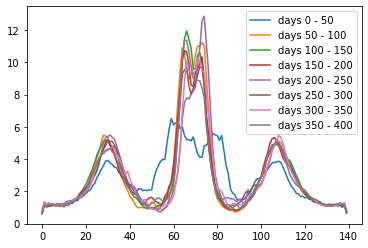

In [46]:
for i in range(8):
    plt.plot(allprecip.isel(Time=slice(200*i,200*(i+1))).mean(["Time","west_east"]),label="days %i - %i"%(i*50,(i+1)*50))
plt.legend()

In [47]:
allprecip=allprecip.isel(Time=slice(200,len(allprecip.Time)))

# Mean

## Over tropics

Each day corresponds to 1600 measurements. Under the assumption that all grid cells have independent precip, all following the same law, of variance 5mm/day, 40000 measurements (ie 25 days) are supposed to be enough to get the mean precip within .05mm/day, with 95% confidence


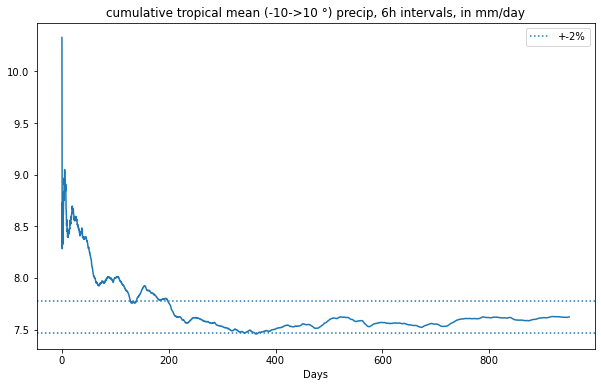

In [48]:
troplim=10
tropicprecip_timeseries = allprecip.sel(south_north=slice(70-troplim,70+troplim)).mean(['south_north','west_east']).load()

fig, ax = plt.subplots(1,1,figsize=(10,6))
ax.set_title('cumulative tropical mean (%i->%i °) precip, 6h intervals, in mm/day'%(-troplim,troplim))
cummean_trop=np.cumsum(np.array(tropicprecip_timeseries))/np.arange(1,len(tropicprecip_timeseries)+1,1.)
ax.plot(np.arange(0,len(tropicprecip_timeseries)/4,0.25),cummean_trop)
ax.axhline(np.max(0.98*cummean_trop[-1:]),linestyle="dotted",label="+-2%")
ax.axhline(np.min(1.02*cummean_trop[-1:]),linestyle="dotted")
ax.legend()
ax.set_xlabel('Days')
print("Each day corresponds to %i measurements. Under the assumption that all grid cells have independent precip, all following the same law, of variance 5mm/day, 40000 measurements (ie %i days) are supposed to be enough to get the mean precip within .05mm/day, with 95%% confidence"%(80*2*troplim,40000/(80*2*troplim)))

## Over mountain

Each day corresponds to 30 measurements. Under the assumption that all grid cells have independent precip, all following the same law, of variance 5mm/day, 40000 measurements (ie 1333 days) are supposed to be enough to get the mean precip within .05mm/day, with 95% confidence


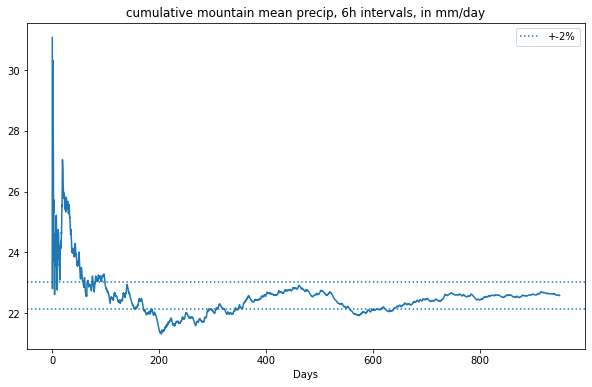

In [49]:
mtnprecip_timeseries = mean_mountain(allprecip).load()

fig, ax = plt.subplots(1,1,figsize=(10,6))
ax.set_title('cumulative mountain mean precip, 6h intervals, in mm/day')
cummean_mtn=np.cumsum(np.array(mtnprecip_timeseries))/np.arange(1,len(mtnprecip_timeseries)+1,1.)
ax.plot(np.arange(0,len(mtnprecip_timeseries)/4,0.25),cummean_mtn)
ax.axhline(np.max(0.98*cummean_mtn[-1:]),linestyle="dotted",label="+-2%")
ax.axhline(np.min(1.02*cummean_mtn[-1:]),linestyle="dotted")
ax.legend()
ax.set_xlabel('Days')
print("Each day corresponds to %i measurements. Under the assumption that all grid cells have independent precip, all following the same law, of variance 5mm/day, 40000 measurements (ie %i days) are supposed to be enough to get the mean precip within .05mm/day, with 95%% confidence"%(30,40000//30))

# Extremes

## 99th percentile

In [50]:
%%time
time_disc = 8
troplim=10

cum99_trop=[]
for i in range(1,len(allprecip.Time)//time_disc+1):
    cum99_trop.append(np.quantile(np.array(allprecip.isel(Time=slice(0,i*time_disc)).sel(south_north=slice(70-troplim,70+troplim))).reshape(-1),0.99))

CPU times: user 42 s, sys: 1.94 s, total: 43.9 s
Wall time: 33.1 s


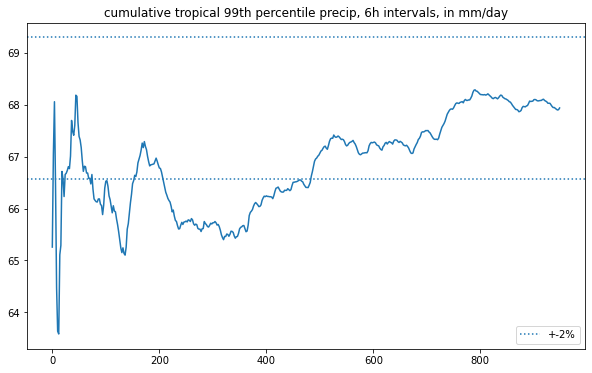

In [51]:
fig, ax = plt.subplots(1,1,figsize=(10,6))
ax.set_title('cumulative tropical 99th percentile precip, 6h intervals, in mm/day')
days = np.arange(0,len(tropicprecip_timeseries)/4,0.25*time_disc)
ax.plot(days,cum99_trop)
ax.axhline(np.max(0.98*cum99_trop[-1]),linestyle="dotted",label="+-2%")
ax.axhline(np.min(1.02*cum99_trop[-1]),linestyle="dotted")
ax.legend()

## 99th percentile over mountain

In [52]:
%%time
time_disc = 8
cum99_mtn=[]
for i in range(1,len(tropicprecip_timeseries)//time_disc+1):
    cum99_mtn.append(np.quantile(np.array(sel_crosseqtropicmountain(allprecip).isel(Time=slice(0,i*time_disc))).reshape(-1),0.99))

CPU times: user 29.9 s, sys: 1.88 s, total: 31.7 s
Wall time: 21 s


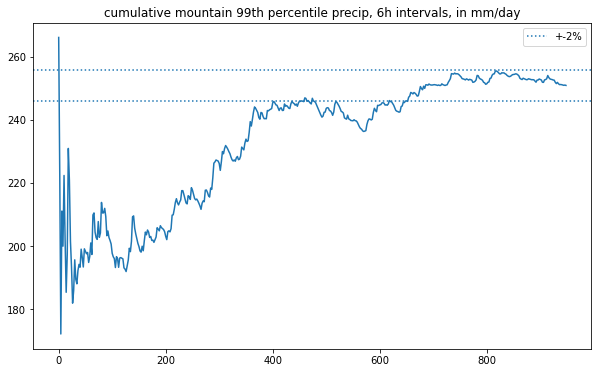

In [53]:
fig, ax = plt.subplots(1,1,figsize=(10,6))
ax.set_title('cumulative mountain 99th percentile precip, 6h intervals, in mm/day')
days = np.arange(0,len(tropicprecip_timeseries)/4,0.25*time_disc)
ax.plot(days,cum99_mtn)
ax.axhline(np.max(0.98*cum99_mtn[-1]),linestyle="dotted",label="+-2%")
ax.axhline(np.min(1.02*cum99_mtn[-1]),linestyle="dotted")
ax.legend()

In [54]:
%%time

def sel_crosseqtropicmountainups(ds):
    return ds.sel(west_east=slice(39,41),south_north=slice(64,75))
time_disc = 8
cum99_mtnups=[]
for i in range(1,len(tropicprecip_timeseries)//time_disc+1):
    cum99_mtnups.append(np.quantile(np.array(sel_crosseqtropicmountainups(allprecip).isel(Time=slice(0,i*time_disc))).reshape(-1),0.99))

CPU times: user 29.4 s, sys: 2.08 s, total: 31.4 s
Wall time: 20.6 s


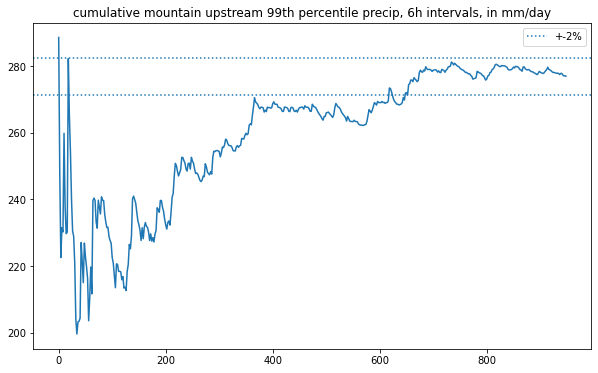

In [55]:
fig, ax = plt.subplots(1,1,figsize=(10,6))
ax.set_title('cumulative mountain upstream 99th percentile precip, 6h intervals, in mm/day')
days = np.arange(0,len(tropicprecip_timeseries)/4,0.25*time_disc)
ax.plot(days,cum99_mtnups)
ax.axhline(np.max(0.98*cum99_mtnups[-1]),linestyle="dotted",label="+-2%")
ax.axhline(np.min(1.02*cum99_mtnups[-1]),linestyle="dotted")
ax.legend()

## 99.9th percentile over mountain

In [56]:
%%time
time_disc = 8
cum999_mtn=[]
for i in range(1,len(tropicprecip_timeseries)//time_disc+1):
    cum999_mtn.append(np.quantile(np.array(sel_crosseqtropicmountain(allprecip).isel(Time=slice(0,i*time_disc))).reshape(-1),0.999))

CPU times: user 30 s, sys: 1.62 s, total: 31.7 s
Wall time: 21 s


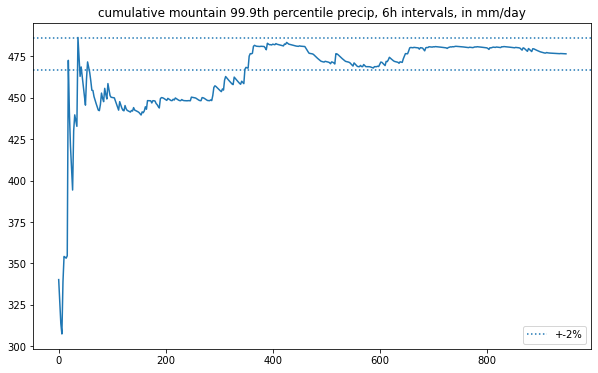

In [57]:
fig, ax = plt.subplots(1,1,figsize=(10,6))
ax.set_title('cumulative mountain 99.9th percentile precip, 6h intervals, in mm/day')
days = np.arange(0,len(tropicprecip_timeseries)/4,0.25*time_disc)
ax.plot(days,cum999_mtn)
ax.axhline(np.max(0.98*cum999_mtn[-1]),linestyle="dotted",label="+-2%")
ax.axhline(np.min(1.02*cum999_mtn[-1]),linestyle="dotted")
ax.legend()

## 95th percentile over mountain

In [58]:
%%time
time_disc = 8
cum95_mtn=[]
for i in range(1,len(tropicprecip_timeseries)//time_disc+1):
    cum95_mtn.append(np.quantile(np.array(sel_crosseqtropicmountain(allprecip).isel(Time=slice(0,i*time_disc))).reshape(-1),0.95))

CPU times: user 30.6 s, sys: 1.88 s, total: 32.5 s
Wall time: 21.6 s


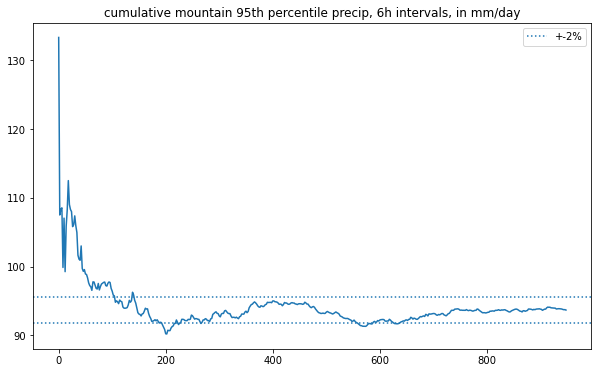

In [59]:
fig, ax = plt.subplots(1,1,figsize=(10,6))
ax.set_title('cumulative mountain 95th percentile precip, 6h intervals, in mm/day')
days = np.arange(0,len(tropicprecip_timeseries)/4,0.25*time_disc)
ax.plot(days,cum95_mtn)
ax.axhline(np.max(0.98*cum95_mtn[-1]),linestyle="dotted",label="+-2%")
ax.axhline(np.min(1.02*cum95_mtn[-1]),linestyle="dotted")
ax.legend()

# All together

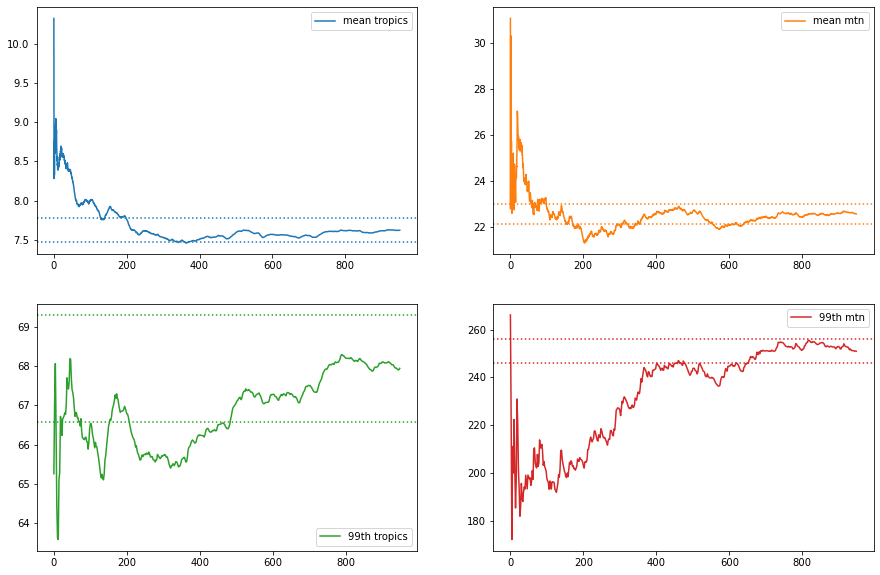

In [61]:
def plot_cumtimeseries(days,ts,ax,color,lbl):
    ax.plot(days,ts,color=color,label=lbl)
    ax.axhline(np.max(0.98*ts[-1]),color=color,linestyle="dotted")
    ax.axhline(np.min(1.02*ts[-1]),color=color,linestyle="dotted")
    ax.legend()
    
colors = plt.rcParams["axes.prop_cycle"].by_key()["color"]
fig, ax = plt.subplots(2,2,figsize=(15,10))
ax=ax.reshape(-1)
i=0
days = np.arange(0,len(tropicprecip_timeseries)/4,0.25)
plot_cumtimeseries(days,cummean_trop,ax[i],colors[i],"mean tropics");i+=1
plot_cumtimeseries(days,cummean_mtn,ax[i],colors[i],"mean mtn");i+=1

days = np.arange(0,len(tropicprecip_timeseries)/4,0.25*time_disc)
plot_cumtimeseries(days,cum99_trop,ax[i],colors[i],"99th tropics");i+=1
plot_cumtimeseries(days,cum99_mtn,ax[i],colors[i],"99th mtn");i+=1